<center>决策树实验</center>

 实验原理：决策树基本算法

输入：训练集 $D=\{(x_1,y_1),(x_2,y_2),...,(x_m,y_m)\}$

属性集：$A=\{a_1,a_2,…,a_d\}$.

过程：函数 TreeGenerate(D,A)

> 1. 生成结点 node;
> 2. if $D$ 中样本全属于同一类别$C$ then
> 3. ​	将node 标记为 $C$ 类叶结点; return
> 4. end if
> 5. if $A=\emptyset$ OR $D$中样本在 $A$ 上取值相同 then
> 6. ​	将 node 标记为叶结点，其类别标记为 $D$ 中样本数最多的类  return
> 7. end if
> 8. 从 $A$ 中选择最优划分属性 $a_*$
> 9. for $a_*$的每一个值$a_*^v$ 
> 10. ​	为 node 生成一个分支;令 $D_V$表示 $D$ 中在 $a_*$ 上取值为$a_*^v$ 的样本子集;
> 11. if $D_V$为空 then
> 12. ​	将分支结点标记为叶结点，其类别标记为 $D$ 中样本最多的类
> 13. else
> 14. 以TreeGenerate($D_v$, $A$\ $\{a_*\}$)为分支结点
> 15. end if
> 16. end for

输出：以node 为根结点的一棵决策树

    
# ID3决策树构建实现

> 根据理论课给出的决策树框架修改课程中的决策树程序代码。

## 模型解构

> createBranch()伪代码：
> 
> 1. 检测数据集中的每个子项是否属于同一分类：
>
> 2. If so return 类标签；
>
> 3. Else
>   1. 寻找划分数据集的最好特征
>   2. 划分数据集
>   3. 创建分支节点
>   4. for 每个划分的子集
>   5.   调用函数createBranch并增加返回结果到分支节点中
>   6. return 分支节点

In [1]:
# 源代码信息
# %load ./code/Ch03/trees.py
'''
Created on Oct 12, 2010
Decision Tree Source Code for Machine Learning in Action Ch. 3
@author: Peter Harrington
'''
from math import log
import operator

使用`createDateSet()`方法可以生成一个小范围数据

In [2]:
def createDataSet():
    dataSet = [[1, 'Y', 'yes'],
               [1, 'Y', 'yes'],
               [1, 'N', 'no'],
               [0, 'Y', 'no'],
               [0, 'Y', 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

In [3]:
myDat, labels=createDataSet()
myDat

[[1, 'Y', 'yes'],
 [1, 'Y', 'yes'],
 [1, 'N', 'no'],
 [0, 'Y', 'no'],
 [0, 'Y', 'no']]

## 最优属性选择

在构建决策树时，确定最优划分属性$a_*$的方法的选择非常关键。

### 样本集信息熵的计算

这里首先引入信息熵，对于样本集合$D$的信息熵可按如下法则计算：

假设样本集合$D$中第$k$类样本所占比例为$p_k$，则$D$的信息熵定义为

$$\text{Ent}(D)=-\sum\limits_{k=1}^{|y|}p_k\log_2p_k$$

`calcShannonEnt()`方法可以对集合样本执行计算

In [4]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt

测试一下：

In [5]:
calcShannonEnt(myDat)

0.9709505944546686

如果我们增大某一变量的取值范围，样本集合的信息熵也对应增大：

In [6]:
myDat[0][-1]='maybe'
myDat

[[1, 'Y', 'maybe'],
 [1, 'Y', 'yes'],
 [1, 'N', 'no'],
 [0, 'Y', 'no'],
 [0, 'Y', 'no']]

In [7]:
calcShannonEnt(myDat)

1.3709505944546687

### 样本集划分

决策树会根据构建的规则，依据样本某一/某些属性的取值做出判断。因此需要构建`splitDataSet()`方法，能实现根据某一属性的取值对样本集进行切割。

In [8]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:#以下分出了某属性的值，将剩余传递
            reducedFeatVec = featVec[:axis]   
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [9]:
splitDataSet(myDat,0,1)

[['Y', 'maybe'], ['Y', 'yes'], ['N', 'no']]

In [10]:
splitDataSet(myDat,0,0)

[['Y', 'no'], ['Y', 'no']]

### 依据信息增益选择最优属性

假设离散属性a有V个可能的取值$\{a_1,a_2....a_v\}$, $a=a_v$的分支对应子集$D^v$

用属性a划分D的信息增益为
$$\text{Gain}(D,a)=\text{Ent}(D)-\sum\limits_{v=1}^V\dfrac{|D_v|}{|D|}\text{Ent}(D^v)$$
$$\text{Gain}(D,a)=\text{Ent}(D)-\text{Ent}(D|a) \tag{1.1}$$

实现能根据属性值对样本进行分割之后，我们可以根据属性值取值划分样本集为若干子集，再依照之前计算样本集信息熵的方法分别计算这些子集的信息熵。最后将计算结果进行比较，留取信息增益较大的子集所属属性为最优属性并在该节点进行划分

In [11]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1 #除标签外属性数
    baseEntropy = calcShannonEnt(dataSet)  
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) #计算当前集合属性的所有取值
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #计算信息增益(公式1.1)
#       if (infoGain > bestInfoGain):  ##优化1：排除信息增益全为0的情况
        if (infoGain >= bestInfoGain): 
            bestInfoGain = infoGain         
            bestFeature = i #当前最佳属性index
    return bestFeature       

In [12]:
myDat

[[1, 'Y', 'maybe'],
 [1, 'Y', 'yes'],
 [1, 'N', 'no'],
 [0, 'Y', 'no'],
 [0, 'Y', 'no']]

In [13]:
print("best Feature:",chooseBestFeatureToSplit(myDat))

best Feature: 0


## 决策树生成

### 叶子节点分类处理
前面已经定义了选择最优属性以及依据最优属性划分决策树的方法。要构建决策树还需要考虑到决策树划分到最后的叶子节点，需要定义叶子节点对结果的选择，一般是选择集合中样本数较多的属性为最终划分属性。所以定义了`majorityCnt()`方法应用于只剩一个属性的情况。

源代码此处<span style="color:red;">报错</span>，考证后原因是：

Python3.x中不再支持`iteritems()`，所以将`iteritems()`改成`items()`，即`dict.items()`

In [14]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
#   sortedClassCount=sorted(classCount.iteritems(),key=operator.itemgetter(1),reverse=True)
## 优化2：修改iteritems()使得代码支持python3
    sortedClassCount=sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

### 决策树生成构建

本例中选择json/dict的方法来存储决策树。这样一种表示方式很利于表示层级数据。

运用之前定义的所有方法来递归地生成决策树，关注决策树递归结束的三个条件、

In [15]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): #样本集标签都属于一类，直接归并
        return classList[0]
    if len(dataSet[0]) == 1: #如果每行只有一列，说明只剩标签了
        return majorityCnt(classList) #用数量最多分类替代
    bestFeat = chooseBestFeatureToSplit(dataSet) 
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    ## 优化3：增加原代码忽略的第三种结束递归条件
    ## 这里不采用西瓜书原算法的补充属性的方式，而是设定default记录所有节点的最大分类数，原因后述。
    myTree[bestFeatLabel]['default'] = majorityCnt(classList)
    return myTree               

In [16]:
myDat, labels=createDataSet()
myTree = createTree(myDat,labels)
myTree

{'no surfacing': {0: 'no',
  1: {'flippers': {'N': 'no', 'Y': 'yes', 'default': 'yes'}},
  'default': 'no'}}

至此生成了判定原数据的决策树。

# CART决策树实现

> 进一步修改代码实现CART决策树程序

## 模型解构

CART生成算法

输入：训练数据集D，停止计算条件

输出：CART决策树

从根节点开始，递归对每个结点操作

> 1. 设结点数据集为$D$，对每个特征$A$的每个值$a$，根据样本点对$A=a$的测试为是或否，将D分为$D_1$，$D_2$，计算$A=a$的基尼指数$ D_1 = \{(x,y) \in D | A(x) = a \},\\ D_2 = D - D_1 $
> 2. 在所有的特征$A$以及所有可能的切分点$a$中，选择**基尼指数最小的特征**和**切分点**，将数据集分配到**两个子结点**中。
> 3. 对两个子结点递归调用1，2步骤
> 4. 生成CART树



## 定义树的数据结构

与上一个实验中使用到的ID3算法相比，使用CART生成算法生成的决策树为**二叉树**，同时选择最优属性的方式不同，但构建过程都是递归构建。

在CART决策树中，最优属性切分点取值构成左子树，右子树则为其他取值，对于非二值属性，右子树将可能有多个取值。所以仅使用字典可能不足以构建CART决策树，需要定义树的数据结构。
```JSON
    {
        featLable : 'feature to split',
        featValue : 'value of feature to split',
        leftChild : {
                feature, value, .....
                     },
        rightChild : {...}
    }
```


## 选择最优属性

### 样本集Gini值的计算

Gini值反映了从数据集D中随机抽取两个样本，其类别标记不一致的概率（可反向表征纯度）。

$$\text{Gini}(D)=\sum\limits_{k=1}^{|y|}\sum\limits_{k'\ne k}p_k p_{k'}=1-\sum\limits_{k=1}^{|y|}p_k^2 $$

In [17]:
def calcGini(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #获取样本中
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    probSquareSum = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        probSquareSum += prob**2
    gini = 1 - probSquareSum
    return gini

### 样本集划分

因为CART决策树为一颗二叉树，所以样本集只需划分为两个子集，需要重新构造样本集划分方法。

同时，这里的样本集划分同上一节不同，上一节是将对应属性的值直接抽出，剩余值交给下一个叶子节点，而这里是把样本集划分为两个列数相同的子集，计算各子集的Gini值，用于得出这一种划分方式的Gini指数以确定该节点的最优划分方式。

In [18]:
def VsplitDataSet(dataSet,axis,value): #根据不同分割为两个子集，用于计算Gini
    leftDataSet = []
    rightDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value: leftDataSet.append(featVec)
        else: rightDataSet.append(featVec)
    return leftDataSet,rightDataSet

def HsplitDataSet(dataSet,axis,value):#去掉本属性后划分为两个子集，用于生成子树
    leftDataSet = []
    rightDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            leftDataSet.append(reducedFeatVec)
        else:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            rightDataSet.append(reducedFeatVec)
    return leftDataSet, rightDataSet

同时也要创建一个纵向分隔的方法，同上。

### 依据Gini指数选择最优属性和划分点

属性$A_i=a$的基尼指数定义为：
$$
Gini\_index(D,A_i(x)=a) = \dfrac{|D_1|}{|D|}\text{Gini}(D_1) + \dfrac{|D_2|}{|D|}\text{Gini}(D_2) 
$$
($D_1 = \{(x,y) \in D | A_i(x) = a \}$)


这里我们选取的是最优的划分方式，所以要对每个属性的每个取值进行遍历。

In [19]:
def chooseBestFeatureValueToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    bestGiniIndex = 1; bestFeature = -1; bestValue = None;
    for i in range(numFeatures):# 遍历属性
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        for value in uniqueVals:# 遍历属性可取值
            GiniIndex = 0.0
            leftDataSet, rightDataSet = VsplitDataSet(dataSet, i, value)
            leftProb = len(leftDataSet)/float(len(dataSet))
            GiniIndex = leftProb * calcGini(leftDataSet) + (1-leftProb) * calcGini(rightDataSet)
            if (GiniIndex < bestGiniIndex): 
                bestGiniIndex = GiniIndex 
                bestFeature = i
                bestValue = value
    return bestFeature,bestValue

In [20]:
myDat

[[1, 'Y', 'yes'],
 [1, 'Y', 'yes'],
 [1, 'N', 'no'],
 [0, 'Y', 'no'],
 [0, 'Y', 'no']]

In [21]:
print("best Feature and its Value: ",chooseBestFeatureValueToSplit(myDat))

best Feature and its Value:  (0, 0)


## 决策树生成

叶子结点的分类处理也已在上一节实现，不再赘述。由于本节`CART`和上节`ID3`仅在最优属性选择上有差别，因此只需要替换原生成树中关键的选择最优属性方法为本节实现的方法即可。

In [22]:
def removeAll(index, L):
#用于删除属性名返回新列表。这里如用del,左右子树重复删除可能带来错误
    newList = []
    for i in range(len(L)):
        if i != index:
            newList.append(L[i])
    return newList

def createTreeByGini(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat,bestVal = chooseBestFeatureValueToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    leftChild, rightChild = HsplitDataSet(dataSet, bestFeat, bestVal)
    if len(rightChild) == 0: return createTreeByGini(leftChild,labels)
    #此时，仅有一属性，且该属性下只有一种取值，按分割方法，右子树将分到空样本集。而测试集的该属性不一定只有一种取值，所以针对取值不满足分割点的取值（右子树），仍用最大vote替换（也就是左子树的结果），这样至少可以返回一定结果。这也是西瓜书终止递归条件三。
    mytree = {'featLabel':bestFeatLabel,'featValue':bestVal}
    labels = removeAll(bestFeat, labels)
    mytree['leftChild'] = createTreeByGini(leftChild,labels)
    mytree['rightChild'] = createTreeByGini(rightChild,labels)
    return mytree  

In [23]:
myDat, labels=createDataSet()
myTreeG = createTreeByGini(myDat,labels)
myTreeG

{'featLabel': 'no surfacing',
 'featValue': 0,
 'leftChild': 'no',
 'rightChild': {'featLabel': 'flippers',
  'featValue': 'N',
  'leftChild': 'no',
  'rightChild': 'yes'}}


根据CART算法划分得到的决策树如上。

就课本提供的小批量生成数据而言，二者产生的决策树很相似且分支很少，一定程度上并不能完全说明这两种划分最优属性算法的优劣。

另外，使用这样的小批量数据不能够检验出构建代码的问题，前面的一些修改都是我在基于后续数据的实验中发现并改正的。

在下一节中将使用Titanic数据集就这两种算法进行训练和验证。

# 决策树测试训练和验证

> 使用Titanic数据集，应用留出法、交叉验证法，用上述两种决策树程序进行训练和验证；

## Titanic数据集读取与预处理

```
/titanic8120 
  | ---- train.csv   #训练集数据
  | ---- test.csv    #测试集数据（没有正确答案，不使用）
  | ---- gender_submmission.csv  #假设只有女性乘客幸存的预测，提交案例。（无用）
    
```
收集和准备数据的流程已经完成，现在应该对数据进行分析和初步的预处理

### 读入数据与描述分析



In [24]:
import numpy as np
import pandas as pd
pd.options.display.latex.repr = True

In [25]:
titanic = pd.read_csv('./data/titanic8120/train.csv')
display(titanic.head().iloc[:,:4])
print("续表")
display(titanic.head().iloc[:,4:])
print(titanic.shape)

,PassengerId,Survived,Pclass,Name
0,1,0,3,"Braund, Mr. Owen Harris"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,1,3,"Heikkinen, Miss. Laina"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,5,0,3,"Allen, Mr. William Henry"


续表


,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,female,35.0,1,0,113803,53.1000,C123,S
4,male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)



一共有891行数据，12个字段。其中`Survived`列表示乘客存活情况(0,1)，应该成为本次预测的标签。`Pclass`为船票等级（1,2,3)，`Sex`为性别，`Age`为年龄，`Sibsp`表示乘客是否有兄弟姐妹或配偶同行，`Parch`表示乘客是否有父母子女同行，`Fare`为船票费用，`Embarked`为登船港口(C,Q,S)。其余的字段如年龄、船票号码、船舱号码是其他标识乘客的元素，对结果影响可以不计。

### 删除冗余列

已经提到有部分列是冗余的，首先将其删除不参与计算。

In [26]:
titanic = titanic.drop(labels=['PassengerId','Name','Ticket','Cabin'],axis=1)


### 缺失值处理

In [27]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


可以看到，`Age`列缺失值较多，而此列为连续值。就我在之前两节实现的决策树而言，只能处理离散的数据且不具备自动离散化的功能，因此这里我认为采用常规的填充缺失值方式可能带来较大误差，因此我决定**删除**这些缺失值。对`Embarked`列同理。

In [28]:
titanic = titanic.dropna()

### 连续属性离散化
(两种方案运行其一)

#### 基于经验和分布自主划分

`Age`列和`Fare`列都是连续属性，取值较多，如果强行分类可能会造成决策树特别复杂。因此需要将其划分为若干小单元。首先要获取其分布情况

In [29]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<AxesSubplot:>

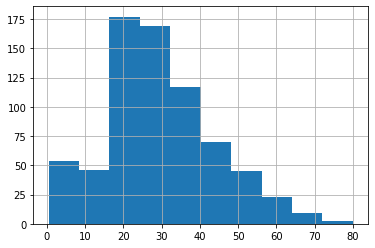

In [30]:
titanic.Age.hist()

<AxesSubplot:>

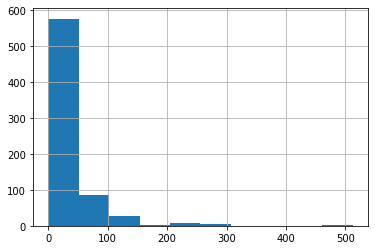

In [31]:
titanic.Fare.hist()

这里我根据分布和经验设定了划分点如下：

In [33]:
def classifyAge(x):
    if x<=16:return "young"
    elif x>50:return "old"
    else: return "mediumAge"

titanic['Age'] = titanic['Age'].map(classifyAge)
titanic.groupby('Age').count().iloc[:,:1]

,Survived
Age,
mediumAge,549
old,63
young,100


In [34]:
def classifyFare(x):
    if x<=20:return "low"
    elif x>50:return "high"
    else: return "mid"

titanic['Fare'] = titanic['Fare'].map(classifyFare)
titanic.groupby('Fare').count().iloc[:,:1]

,Survived
Fare,
high,136
low,391
mid,185


#### 基于信息增益选取划分点

以上是根据经验将离散属性分为三段，而西瓜书介绍了一种基于二分法的划分点选择法，对离散属性取值按大小排列生成的序列中取相邻两个值的中位点作为划分点将样本集划分为两个子集$D^+,D^-$，再依次计算不同划分点的信息增益
$$
\begin{align}
Gain(D,a) &= \max\limits_{t\in T_a} Gain(D,a,t) \\ &= \max\limits_{t\in T_a} Ent(D) - \sum\limits_{\lambda \in \{-,+\}} \dfrac{|D_t^\lambda|}{|D|} Ent(D_t^\lambda)
\end{align}
$$
，最后对不同划分点的信息增益进行比较，选取最佳的划分点。

In [32]:
def biSplitDataSet(dataSet, axis, value):
    mDataSet = []
    pDataSet = []
    for featVec in dataSet:
        if featVec[axis] <= value:
            mFeatVec = featVec[:axis]   
            mFeatVec.extend(featVec[axis+1:])
            mDataSet.append(mFeatVec)
        else:
            pFeatVec = featVec[:axis]   
            pFeatVec.extend(featVec[axis+1:])
            pDataSet.append(pFeatVec)
    return mDataSet,pDataSet

def getSplitPin(dataSet,axis):
    colValues = sorted(list(set([row[axis] for row in dataSet])))
    minEntropy = 1.0
    bestSplit = -1
    for value in colValues:
        mSet,pSet = biSplitDataSet(dataSet,axis,value)
        mProb = len(mSet)/float(len(dataSet))
        newEntropy = mProb*calcShannonEnt(mSet) + (1-mProb)*calcShannonEnt(pSet)
        if newEntropy <= minEntropy:
            minEntropy = newEntropy
            bestSplit = value
    return bestSplit 

In [33]:
titanic_survive = titanic['Survived']
titanic_X = titanic.drop(labels=['Survived'],axis=1)
titanic_labels = titanic_X.columns.tolist()
print("Label: ",titanic_labels)
titanic_data = titanic[titanic_labels+['Survived']].values.tolist()
ageSplit = getSplitPin(titanic_data,2)
fareSplit = getSplitPin(titanic_data,5)
print('ageSplit: ',ageSplit)
print('fareSplit:',fareSplit)

def classifyAge(x):
    if x<=ageSplit:return "young"
    else:return "old"
titanic['Age'] = titanic['Age'].map(classifyAge)
display(titanic.groupby('Age').count().iloc[:,:1])

def classifyFare(x):
    if x<=fareSplit:return "low"
    else: return "high"
titanic['Fare'] = titanic['Fare'].map(classifyFare)
display(titanic.groupby('Fare').count().iloc[:,:1])

Label:  ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
ageSplit:  6.0
fareSplit: 10.4625


,Survived
Age,
old,665
young,47


,Survived
Fare,
high,473
low,239


### 数据类型转换

将Dateframe格式的数据抽出X和Y，放入输入要求的数组中。

In [34]:
titanic_survive = titanic['Survived']
titanic_X = titanic.drop(labels=['Survived'],axis=1)
titanic_labels = titanic_X.columns.tolist()
print("Label: ",titanic_labels)
titanic_data = titanic[titanic_labels+['Survived']].values.tolist()

Label:  ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [35]:
display(titanic_data[:3])

[[3, 'male', 'old', 1, 0, 'low', 'S', 0],
 [1, 'female', 'old', 1, 0, 'high', 'C', 1],
 [3, 'female', 'old', 0, 0, 'low', 'S', 1]]

## 创建分类评估方法

对于ID3决策树，我修改源码中的`classify()`方法，并基于此构造一个可用于测试集的评估方法，返回准确率来评价学习器泛化误差。

对于CART决策树，因为代码是自行撰写，所以需要针对新的树结构来仿写classify方法和测试方法。

In [36]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    if key in secondDict.keys():
        valueOfFeat = secondDict[key]
        if isinstance(valueOfFeat, dict): 
            classLabel = classify(valueOfFeat, featLabels, testVec)
        else: classLabel = valueOfFeat
    else: classLabel = secondDict['default']
    return classLabel

def classifyBiTree(inputTree,featLabels,testVec):
    featLabel = inputTree['featLabel']
    featValue = inputTree['featValue']
    featIndex = featLabels.index(featLabel)
    value = testVec[featIndex]
    if value == featValue:
        if isinstance(inputTree['leftChild'], dict):
            classLabel = classifyBiTree(inputTree['leftChild'],featLabels,testVec)
        else:
            classLabel = inputTree['leftChild']
    else: 
        if isinstance(inputTree['rightChild'],dict):
            classLabel = classifyBiTree(inputTree['rightChild'],featLabels,testVec)
        else:
            classLabel = inputTree['rightChild']
    return classLabel

def test(x_test,y_test,tree,labels):
    correct = 0
    for i in range(len(x_test)):
        label = y_test[i]
        predict = classify(tree,labels,x_test[i])
        if label == predict: correct += 1
    precision = correct/float(len(x_test))
    return precision,correct,len(x_test)

def testBiTree(x_test,y_test,tree,labels):
    correct = 0
    for i in range(len(x_test)):
        label = y_test[i]
        predict = classifyBiTree(tree,labels,x_test[i])
        if label == predict: correct += 1
    precision = correct/float(len(x_test))
    return precision,correct,len(x_test)

## 留出法

留出法是直接将数据集划分为两个互斥的集合。但是要尽可能保持数据分布的一致性，也就是分层采样。

在`sklearn.model_selection`中具有这样一个方法`train_test_split()`可以实现样本集的分割。

分层抽样需要考虑其中的`stratify`参数指定为Y标签，保持**数据分布一致性**。设定`test_size`可以控制测试集所占比例。

In [37]:
from sklearn.model_selection import train_test_split

titanic_labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
titanic_X = titanic[titanic_labels].values
titanic_Y = titanic['Survived'].values

EPOCH = 3 #轮数。不同轮给不同random_state以不同方式划分
print('ID3 Decision Tree')
precision_overall = 0.0
for i in range(EPOCH):#若干次随机划分、重复实验取平均值
    X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_Y, test_size = 0.2, random_state = 100+i, stratify = titanic_Y)
    titanic_train = np.concatenate((X_train, y_train.reshape(-1, 1)),axis=1)
    titanic_test = np.concatenate((X_test, y_test.reshape(-1, 1)),axis=1)
    titanicTreeI = createTree(titanic_train.tolist(), titanic_labels.copy())
    precision,correct,length = test(X_test,y_test,titanicTreeI,titanic_labels.copy())
    precision_overall += precision
    print('EPOCH %d/%d. Precision:%.3f.\t\t(%d correct out of %d)' % (i+1,EPOCH,precision,correct,length))
print('Overall Precision: %.3f\n' % (precision_overall/EPOCH))

precision_overall = 0.0
print('CART Decision Tree')
for i in range(EPOCH):#若干次随机划分、重复实验取平均值
    X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_Y, test_size = 0.2, random_state = 200+i, stratify = titanic_Y)
    titanic_train = np.concatenate((X_train, y_train.reshape(-1, 1)),axis=1)
    titanic_test = np.concatenate((X_test, y_test.reshape(-1, 1)),axis=1)
    titanicTreeG = createTreeByGini(titanic_train.tolist(), titanic_labels.copy())
    precision,correct,length = testBiTree(X_test,y_test,titanicTreeG,titanic_labels.copy())
    precision_overall += precision
    print('EPOCH %d/%d. Precision:%.3f.\t\t(%d correct out of %d)' % (i+1,EPOCH,precision,correct,length))
print('Overall Precision: %.3f' % (precision_overall/EPOCH))


ID3 Decision Tree
EPOCH 1/3. Precision:0.811.		(116 correct out of 143)
EPOCH 2/3. Precision:0.783.		(112 correct out of 143)
EPOCH 3/3. Precision:0.776.		(111 correct out of 143)
Overall Precision: 0.790

CART Decision Tree
EPOCH 1/3. Precision:0.790.		(113 correct out of 143)
EPOCH 2/3. Precision:0.769.		(110 correct out of 143)
EPOCH 3/3. Precision:0.734.		(105 correct out of 143)
Overall Precision: 0.765


## 交叉验证法

交叉验证法是将数据集分层采样划分为k个大小相似的互斥子集，每次用k-1个子集的并集作为训练集，余下1个子集作为测试集。

同样在`sklearn.cross_validation`中有`KFold()`和`StratifiedKFold()`等。后者可以实现分层抽样，保持**数据分布的一致性**。

In [38]:
from sklearn.model_selection import StratifiedKFold

titanic_labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
titanic_X = titanic[titanic_labels].values
titanic_Y = titanic['Survived'].values

print('ID3 Decision Tree');print("-"*30)
EPOCH = 3
precision_overall = 0.0
for j in range(EPOCH):
    N = 5 # 标识折数
    skf = StratifiedKFold(n_splits=N,random_state=100+j,shuffle=True)
    i = 0
    precision_epoch = 0.0
    for train_idx,test_idx in skf.split(titanic_X, titanic_Y):
        X_train,X_test,y_train,y_test = titanic_X[train_idx],titanic_X[test_idx],titanic_Y[train_idx],titanic_Y[test_idx]
        titanic_train = np.concatenate((X_train, y_train.reshape(-1, 1)),axis=1)
        titanic_test = np.concatenate((X_test, y_test.reshape(-1, 1)),axis=1)
        titanicTreeI = createTree(titanic_train.tolist(), titanic_labels.copy())
        precision,correct,length = test(X_test,y_test,titanicTreeI,titanic_labels.copy())
        precision_epoch += precision
        print('Fold %d/%d. Precision:%.3f.\t\t(%d correct out of %d)' % (i+1,N,precision,correct,length))
        i += 1
    print("EPOCH %d/%d, Precision %.3f\n"%(j+1,EPOCH,precision_epoch/N))
    precision_overall += precision_epoch/N
print("="*30);print("Overall Precision: %.3f" % (precision_overall/EPOCH))

print('\nCART Decision Tree');print("-"*30)
EPOCH = 3
precision_overall = 0.0
for j in range(EPOCH):
    N = 5
    skf = StratifiedKFold(n_splits=N,random_state=200+j,shuffle=True)
    i = 0
    precision_epoch = 0.0
    for train_idx,test_idx in skf.split(titanic_X, titanic_Y):
        X_train,X_test,y_train,y_test = titanic_X[train_idx],titanic_X[test_idx],titanic_Y[train_idx],titanic_Y[test_idx]
        titanic_train = np.concatenate((X_train, y_train.reshape(-1, 1)),axis=1)
        titanic_test = np.concatenate((X_test, y_test.reshape(-1, 1)),axis=1)
        titanicTreeG = createTreeByGini(titanic_train.tolist(), titanic_labels.copy())
        precision,correct,length = testBiTree(X_test,y_test,titanicTreeG,titanic_labels.copy())
        precision_epoch += precision
        print('Fold %d/%d. Precision:%.3f.\t\t(%d correct out of %d)' % (i+1,N,precision,correct,length))
        i+=1
    print("EPOCH %d/%d, Precision %.3f\n"%(j+1,EPOCH,precision_epoch/N))
    precision_overall += precision_epoch/N
print("="*30);print("Overall Precision: %.3f" % (precision_overall/EPOCH))

ID3 Decision Tree
------------------------------
Fold 1/5. Precision:0.818.		(117 correct out of 143)
Fold 2/5. Precision:0.741.		(106 correct out of 143)
Fold 3/5. Precision:0.775.		(110 correct out of 142)
Fold 4/5. Precision:0.803.		(114 correct out of 142)
Fold 5/5. Precision:0.845.		(120 correct out of 142)
EPOCH 1/3, Precision 0.796

Fold 1/5. Precision:0.804.		(115 correct out of 143)
Fold 2/5. Precision:0.762.		(109 correct out of 143)
Fold 3/5. Precision:0.725.		(103 correct out of 142)
Fold 4/5. Precision:0.817.		(116 correct out of 142)
Fold 5/5. Precision:0.775.		(110 correct out of 142)
EPOCH 2/3, Precision 0.777

Fold 1/5. Precision:0.804.		(115 correct out of 143)
Fold 2/5. Precision:0.776.		(111 correct out of 143)
Fold 3/5. Precision:0.852.		(121 correct out of 142)
Fold 4/5. Precision:0.775.		(110 correct out of 142)
Fold 5/5. Precision:0.732.		(104 correct out of 142)
EPOCH 3/3, Precision 0.788

Overall Precision: 0.787

CART Decision Tree
---------------------------

# sk-learn 决策树应用*

> 使用scikit-learn工具包，实现Titanic数据集的决策树分类，并尝试进行优化。

sklearn决策树的使用非常简单，使用`fit()`训练模型，使用`predict()`测试模型即可。同样仿照本次实验123部分，分为两种决策树，在构建时控制`criterion`参数即可。


## 数据处理

sklearn的决策树和自建决策树不同，不能接收字符型变量，因此需要对数据中字符型变量进行转换。


In [39]:
titanic_labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# sklearn的决策树不能处理字符型变量
titanic['Sex'] = titanic['Sex'].astype("category").cat.codes
titanic['Age'] = titanic['Age'].astype("category").cat.codes
titanic['Fare'] = titanic['Fare'].astype("category").cat.codes
titanic['Embarked'] = titanic['Embarked'].astype("category").cat.codes
titanic_X = titanic[titanic_labels].values
titanic_Y = titanic['Survived'].values

## 基于信息熵的决策树

In [44]:
from sklearn import tree
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_Y, test_size = 0.2, random_state = 235, stratify = titanic_Y)

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
test_score  = clf.score(X_test,y_test)

print("Train Score: %.3f; Test Score %.3f." % (train_score,test_score))

Train Score: 0.851; Test Score 0.825.


## 基于Gini指数的决策树

In [45]:
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_Y, test_size = 0.2, random_state = 517, stratify = titanic_Y)

clf = tree.DecisionTreeClassifier(criterion='gini')
clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
test_score  = clf.score(X_test,y_test)

print("Train Score: %.3f; Test Score %.3f." % (train_score,test_score))

Train Score: 0.849; Test Score 0.797.


使用sklearn生成的树为dot格式，可以借助`graphviz`来生成可视化格式。

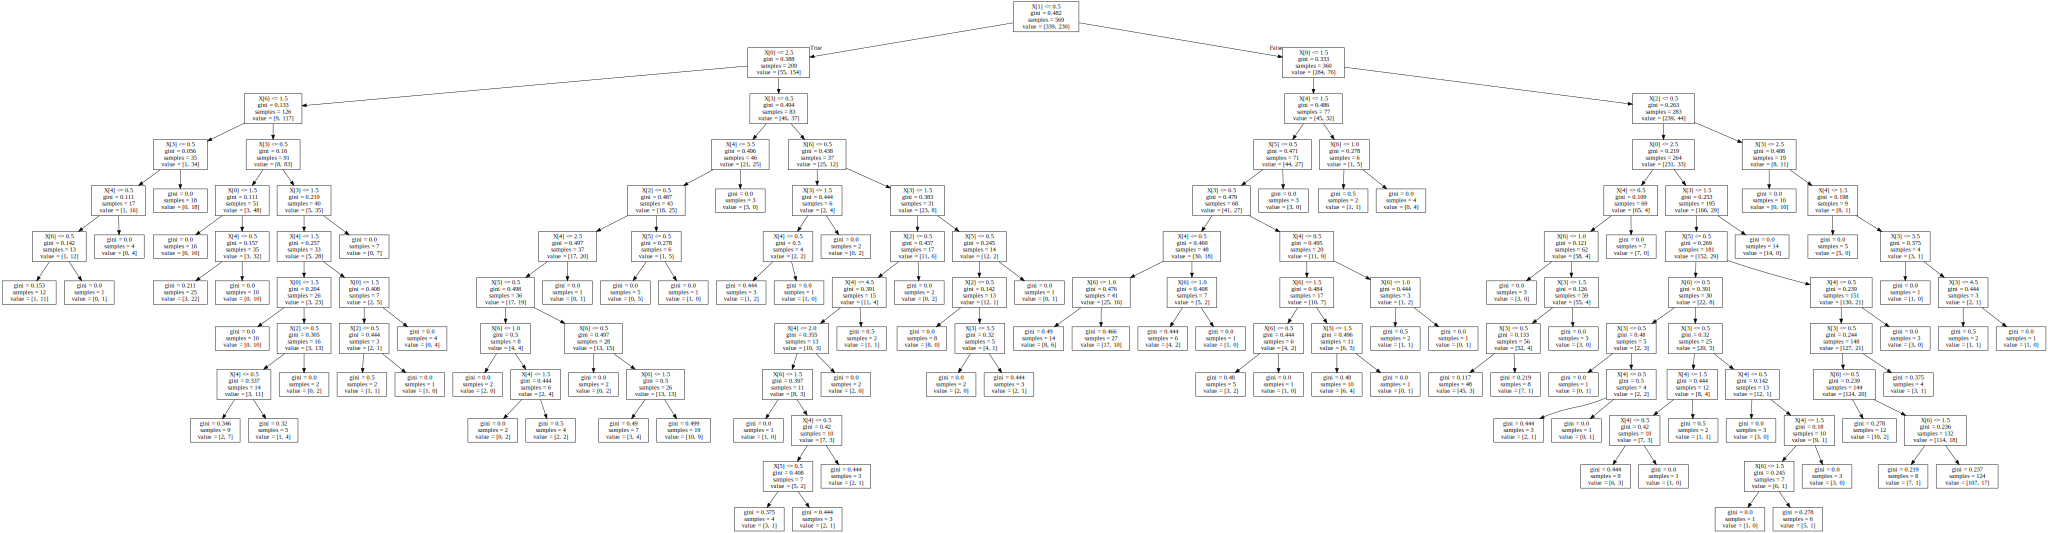

In [42]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data,format='svg')
graph

## 优化尝试——调整树深度

构造决策树时，可以控制`max_depth`参数限定树的深度，比较获得较好的结果。我们一共有7个属性，所以理论上树的最大深度为7，可以对不同深度展开测试。

当控制深度小于最大深度时，决策树会进行剪枝操作，这样可以一定程度上缓解过拟合问题；但如果层数不够，模型性能可能一般。

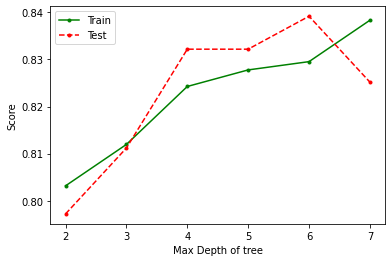

In [50]:
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_Y, test_size = 0.2, random_state = 235, stratify = titanic_Y)
def deepTree(depth=7):
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score  = clf.score(X_test,y_test)
    return train_score, test_score

train_score = []
test_score = []
depths = [2,3,4,5,6,7]
for i in depths:
    trs,tes = deepTree(i)
    train_score.append(trs)
    test_score.append(tes)

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Max Depth of tree')
plt.ylabel('Score')
plt.plot(depths,train_score,'.g-',label='Train')
plt.plot(depths,test_score,'.r--',label='Test')
plt.legend()
    

可以观察到，限定最大深度为6可以一定程度上减少过拟合的影响，在测试集上表现较好。

# 实验总结

完成了本次实验的基本要求，通过自己复现决策树的构建，我对于决策树的知识有了更深的掌握。同时这次书本提供的代码存在一些不严谨的问题，通过反复修改和检查也能够检验自己的认知是否正确。我的主要收获和改进如下：

1. **原代码未考虑信息增益可能为0的情况**

根据公式推导，信息增益值是一个不小于0的值，是有可能取值为0的。原代码在选取最佳属性值时，初始值为0，比较的符号是大于，如果出现类似以下样本集：

| index | X | Y |
| :--: | :--: | :--: |
| 0 | 0 | 0 |
| 1 | 0 | 1 |
| 2 | 1 | 0 |
| 3 | 1 | 1 |

使用属性X划分的子集信息熵之和与样本集信息熵相等，信息增益为0，则不会选取X为最优属性，而其他属性情况类似或不存在其他的属性时，则整个流程没有选取属性。所以可以将符号更改为$\ge$或初始值调整为负值。



2. **训练集中划分最优属性后，当前子集的该属性所有取值并不一定取了所有可能取值**
这是西瓜书74页决策树算法11行的问题，原代码里没有考虑。

在使用Titanic数据集验证决策树时，发现了《实战》书决策树代码的算法性问题，在《实战》书上对决策树算法的伪代码描述较为简单。原代码（ID3)在选择好划分的最优属性后，仅仅取了当前传入子集在该属性上的所有取值来划分样本集：
```Python
# ... ↑选择最优属性等操作
featValues = [example[bestFeat] for example in dataSet]
uniqueVals = set(featValues)
for value in uniqueVals:
    #... 划分子集建立分支的操作
```
在使用Titanic测试集验证时，程序出现了`Keyerror`报错，原因就是某一分支下，训练集所取的属性值不能完全覆盖所有可能取值，导致建立的分支不够，使用模型预测时出现了无法判断的情况。参考笔记、西瓜书后发现，西瓜书上的[决策树算法](#实验原理：决策树基本算法)第11-13行考虑了这种情况。（如果第9行选取的$a_*^v$仅是当前传入子集$D$上的可取值的话，就不可能出现$D_v$为空的情况了）

因此，我对原来的代码进行了更改，对每个非叶子节点都增加一个default选项，用于标记当前传入集合$D$中样本最多的类，同时对`classify()`方法增加了key不存在直接返回default结果的代码。这样做会增大树的存储冗余，但是之所以这么做是因为每次递归创建子树时所传入的参数并不能够完全揭示属性的所有可能取值，另创方法代价太大；而且训练模型时本就不应该将测试集纳入考虑范围，创建default分支一定程度上加强了程序的健壮性，面对测试集的意外输入也能够返回一个合理的值。



3. 部分代码保留了Python2特性，直接运行会报错，通过查找资料已经予以修正。



4. 一开始将数据集中的测试文件和样例文件当作测试集使用了，但是通过查找数据源描述发现样例仅供提示提交格式，虽然id和测试文件对应，但是官方的描述是**假定女性乘客全部存活**的结果，所以并不是正确答案，引入可能对模型评估产生影响。



5. `graphviz`包不仅要使用`pip`命令在python环境中安装，还需要单独在系统环境中安装，否则无法生效。

以CentOS操作系统为例，需要单独安装graphviz。

```bash
pip install graphviz
yum -y install graphviz
```